# Predicting Insuarance on raw data using linear Regression

In [1]:
import os
import pandas as pd
import numpy as np

### Loading Train and Test Data

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import gc

import matplotlib.pyplot as plt
import seaborn as sns

# Load separate train and test datasets
TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"

print("Loading datasets...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

Loading datasets...
Train shape: (1200000, 21), Test shape: (800000, 20)


### Preprocessing

In [3]:
# Ensure training target exists
TARGET_COL = "Premium Amount"
if TARGET_COL not in df_train.columns:
    raise RuntimeError(f"Expected a '{TARGET_COL}' column in train.csv")

# Separate features/targets for train
X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]

# Check for missing values in target
if y_train.isna().any():
    print(f"Warning: Found {y_train.isna().sum()} missing values in target. Removing those rows...")
    mask = ~y_train.isna()
    X_train = X_train[mask]
    y_train = y_train[mask]
    print(f"New training size: {len(X_train):,}")

del df_train  # Free memory
gc.collect()

# For test, check whether ground-truth target is provided
if TARGET_COL in df_test.columns:
    X_test = df_test.drop(columns=[TARGET_COL])
    y_test = df_test[TARGET_COL]
    has_test_target = True
else:
    X_test = df_test.copy()
    y_test = None
    has_test_target = False
del df_test  # Free memory
gc.collect()

# Identify numeric and categorical columns from training features
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Check for missing values
missing_train = X_train.isnull().sum()
if missing_train.sum() > 0:
    print(f"\n⚠ Found {missing_train.sum():,} missing values in training features")
    print("Top columns with missing values:")
    print(missing_train[missing_train > 0].sort_values(ascending=False).head())

print(f"\nFeatures: {len(numeric_cols)} numeric, {len(categorical_cols)} categorical")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")


⚠ Found 1,203,748 missing values in training features
Top columns with missing values:
Previous Claims         364029
Occupation              358075
Credit Score            137882
Number of Dependents    109672
Customer Feedback        77824
dtype: int64

Features: 9 numeric, 11 categorical
Training samples: 1,200,000
Test samples: 800,000


### Preprocessing pipelines with imputation

In [4]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing numeric values with median
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing categorical with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop',
    sparse_threshold=0.3
)

### Pipeline with Linear Regression

In [5]:
# Pipeline with linear regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', LinearRegression(n_jobs=-1))  # Use all CPU cores
])

# Fit on training data
print("\n" + "="*60)
print("Training linear regression model...")
print("This may take a few minutes with large datasets...")
print("="*60)

pipeline.fit(X_train, y_train)
print("✓ Training complete!")

# Free memory after training
del X_train, y_train
gc.collect()


Training linear regression model...
This may take a few minutes with large datasets...
✓ Training complete!


23

### Generate predictions on test set

In [6]:
print("\nGenerating predictions on test set...")
y_pred = pipeline.predict(X_test)
print("Predictions complete!")


Generating predictions on test set...
Predictions complete!


### Test Set Results & Metrics


Saving predictions to CSV...

✓ Test set does not contain 'Premium Amount'.
✓ Predictions saved to: ../data/predictions_linear_regression.csv

                 PREDICTION STATISTICS
  Min  : $     -214.55
  Max  : $    5,089.86
  Mean : $    1,101.76
  Std  : $      366.73


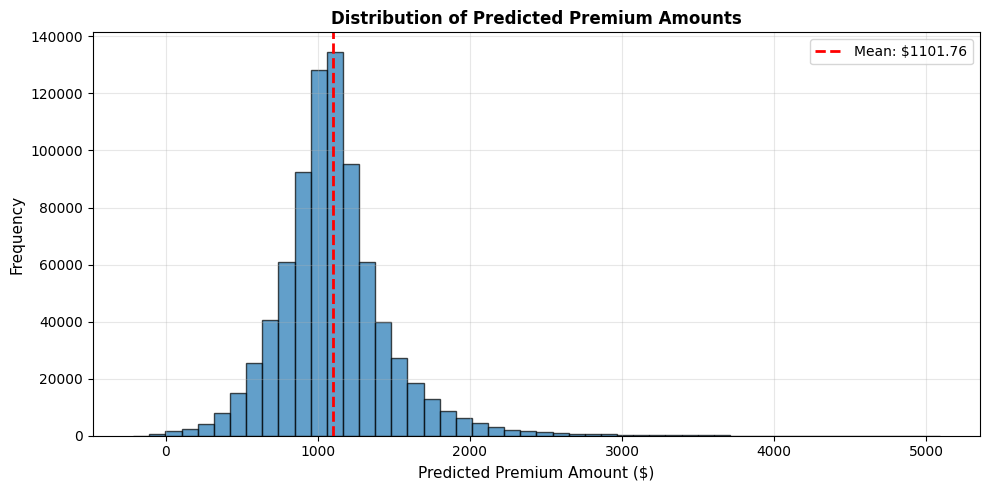


✓ All done!


In [7]:

# Ensure predictions are numpy arrays to avoid attribute issues (e.g., tuple vs array)
# Force float64 so sklearn metrics receive a proper ndarray type
y_pred = np.asarray(y_pred, dtype=np.float64)

# If test ground-truth is available, compute metrics
if has_test_target:
    # reassure the type-checker that y_test is not None
    assert y_test is not None

    # Convert y_test to a 1D numpy float64 array for consistent indexing / math.
    # Prefer pandas' to_numpy when available, fall back to values or np.asarray,
    # then ravel to ensure a 1-D shape.
    if hasattr(y_test, "to_numpy"):
        y_test_arr = y_test.to_numpy(dtype=np.float64)
    elif hasattr(y_test, "values"):
        y_test_arr = np.asarray(y_test.values, dtype=np.float64)
    else:
        y_test_arr = np.asarray(y_test, dtype=np.float64)

    # Ensure it's a 1-D float64 ndarray (no ExtensionArray or pandas-backed array)
    y_test_arr = np.ravel(y_test_arr).astype(np.float64, copy=False)

    mae = mean_absolute_error(y_test_arr, y_pred)
    # Compute RMSE directly using numpy to avoid relying on a function that may not be available.
    rmse = np.sqrt(np.mean((y_test_arr - y_pred) ** 2))
    r2 = r2_score(y_test_arr, y_pred)
    
    # Avoid divide-by-zero in MAPE by masking zeros (use numpy mask)
    mask = (y_test_arr != 0)
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_test_arr[mask] - y_pred[mask]) / y_test_arr[mask])) * 100
    else:
        mape = float('nan')

    print("\n" + "="*60)
    print("                    TEST SET RESULTS")
    print("="*60)
    print(f"  MAE  (Mean Absolute Error)    : ${mae:,.2f}")
    print(f"  RMSE (Root Mean Squared Error): ${rmse:,.2f}")
    print(f"  R²   (R-squared)              : {r2:.4f}")
    print(f"  MAPE (Mean Abs % Error)       : {mape:.2f}%")
    print("="*60)

    # Sample data for plotting (to avoid memory issues with large scatter plots)
    sample_size = min(10000, len(y_test_arr))
    sample_idx = np.random.choice(len(y_test_arr), sample_size, replace=False)
    # Use numpy arrays for the samples
    y_test_sample = y_test_arr[sample_idx]
    y_pred_sample = y_pred[sample_idx]

    # Plots comparing actual vs predicted
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    sns.scatterplot(x=y_test_sample, y=y_pred_sample, alpha=0.4, s=15)
    plt.plot([y_test_arr.min(), y_test_arr.max()], [y_test_arr.min(), y_test_arr.max()], "r--", linewidth=2, label="Perfect Prediction")
    plt.xlabel("Actual Premium Amount ($)", fontsize=11)
    plt.ylabel("Predicted Premium Amount ($)", fontsize=11)
    plt.title(f"Actual vs Predicted (showing {sample_size:,} samples)", fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1,2,2)
    residuals = y_test_arr - y_pred
    sns.histplot(residuals, kde=True, bins=50)
    plt.xlabel("Residuals (Actual - Predicted)", fontsize=11)
    plt.ylabel("Frequency", fontsize=11)
    plt.title("Residual Distribution", fontsize=12, fontweight='bold')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    
    # No ground truth in test set: save predictions to CSV for submission
    print("\nSaving predictions to CSV...")
    submission = pd.DataFrame({
        'id': X_test['id'] if 'id' in X_test.columns else range(len(X_test)),
        'predicted_premium_amount': y_pred
    })
    out_path = '../data/predictions_linear_regression.csv'
    submission.to_csv(out_path, index=False)
    
    print(f"\n✓ Test set does not contain '{TARGET_COL}'.")
    print(f"✓ Predictions saved to: {out_path}")
    print(f"\n" + "="*60)
    print("                 PREDICTION STATISTICS")
    print("="*60)
    # Use numpy functions on the array to avoid attribute errors
    print(f"  Min  : ${np.min(y_pred):>12,.2f}")
    print(f"  Max  : ${np.max(y_pred):>12,.2f}")
    print(f"  Mean : ${np.mean(y_pred):>12,.2f}")
    print(f"  Std  : ${np.std(y_pred):>12,.2f}")
    print("="*60)
    
    # Simple histogram of predictions
    plt.figure(figsize=(10, 5))
    plt.hist(y_pred, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Predicted Premium Amount ($)', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Distribution of Predicted Premium Amounts', fontsize=12, fontweight='bold')
    # Cast numpy scalar to native float to satisfy type-checkers that expect float
    mean_pred = float(np.mean(y_pred))
    plt.axvline(mean_pred, color='r', linestyle='--', linewidth=2, label=f'Mean: ${mean_pred:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
print("\n✓ All done!")

### MODEL ACCURACY METRICS - Training Set Evaluation

In [8]:
# =============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

print("Loading training data for accuracy evaluation...")
df_train_eval = pd.read_csv(TRAIN_PATH)
df_train_eval = df_train_eval.dropna(subset=[TARGET_COL])
X_train_eval = df_train_eval.drop(columns=[TARGET_COL])
y_train_eval = df_train_eval[TARGET_COL]

print(f"Generating predictions on {len(y_train_eval):,} training samples...")
y_train_pred = pipeline.predict(X_train_eval)

# If predict returned a tuple (some custom models) take first element
if isinstance(y_train_pred, tuple):
    y_train_pred = y_train_pred[0]

# Ensure numpy 1-D float arrays for consistent arithmetic / metrics
y_train_pred = np.asarray(y_train_pred, dtype=np.float64).ravel()
if hasattr(y_train_eval, "to_numpy"):
    y_train_arr = y_train_eval.to_numpy(dtype=np.float64)
else:
    y_train_arr = np.asarray(y_train_eval, dtype=np.float64)
y_train_arr = np.ravel(y_train_arr).astype(np.float64, copy=False)

# Calculate all metrics (use the numpy arrays)
mae = mean_absolute_error(y_train_arr, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train_arr, y_train_pred))
r2 = r2_score(y_train_arr, y_train_pred)

# Avoid divide-by-zero for MAPE
mask = (y_train_arr != 0)
if mask.sum() > 0:
    mape = np.mean(np.abs((y_train_arr[mask] - y_train_pred[mask]) / y_train_arr[mask])) * 100
else:
    mape = float('nan')

explained_var = explained_variance_score(y_train_arr, y_train_pred)

# Display results
print("\n" + "="*75)
print(" MODEL PERFORMANCE METRICS ".center(75, "="))
print("="*75)
print(f"\n R² Score: {r2*100:.2f}%")
print(f"   ➜ Model explains {r2*100:.2f}% of the variance in premium amounts")
print(f"\n Explained Variance Score: {explained_var*100:.2f}%")
print(f"\n Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"   ➜ Average prediction error is ${mae:,.2f}")
print(f"\n Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"   ➜ Typical prediction deviation is ${rmse:,.2f}")

if not np.isnan(mape):
    print(f"\n Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"   ➜ Average error is {mape:.2f}% of actual premium amounts")
else:
    print(f"\n Mean Absolute Percentage Error (MAPE): N/A")
    print(f"   ➜ MAPE undefined due to zero values in targets")
    
print("="*75)

if r2 >= 0.9:
    print("\n EXCELLENT Model Performance!")
elif r2 >= 0.7:
    print("\n GOOD Model Performance")
elif r2 >= 0.5:
    print("\n  MODERATE Model Performance")
else:
    print("\n POOR Model Performance - Linear Regression is inadequate")
print("="*75)

Loading training data for accuracy evaluation...
Generating predictions on 1,200,000 training samples...

======================== MODEL PERFORMANCE METRICS ========================

 R² Score: 15.19%
   ➜ Model explains 15.19% of the variance in premium amounts

 Explained Variance Score: 15.19%

 Mean Absolute Error (MAE): $607.72
   ➜ Average prediction error is $607.72

 Root Mean Squared Error (RMSE): $796.59
   ➜ Typical prediction deviation is $796.59

 Mean Absolute Percentage Error (MAPE): 261.54%
   ➜ Average error is 261.54% of actual premium amounts

 POOR Model Performance - Linear Regression is inadequate
